# Variational Autoencoder (VAE) & Conditional Variational Autoencoder (CVAE) in PyTorch

A PyTorch implementation of Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE) for generating and reconstructing MNIST digits. This project explores generative modeling using Deep Neural Networks, leveraging the reparameterization trick and probabilistic inference techniques.

## 📚 Step 1: Importing Necessary Libraries  

Before we begin building the Generative Models, we **import all necessary libraries** that will be used throughout the project.  

---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt



## 🧠 Step 2: VAE (Variational Autoencoder) Implementation

Next, we build the VAE, this will be used to generate images of digits between 0 - 9.

---

In [2]:
class VAE(nn.Module):
    """
    A simple Variational Autoencoder (VAE) for MNIST.
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        # input_dim = 28*28 = 784 for MNIST
        # hidden_dim = 400 is a common choice for MNIST
        # latent_dim = 20 is a common choice for the latent space

        #Tensors in pytorch are objects that store arrays which some special features:
        # 1. They can be used on GPU, which is much faster than CPU. This is unlike regular python and numpy which runs on the CPU

        # 2. They can be used to define a computation graph, which is used for backpropagation. So gradient computation is automatic.

        # 3. They can be used to define a pytorch neural network, which is a function that takes an input and produces an output.

        # 4 . They can be used to define a pytorch loss function, which is a function that takes an input and produces a scalar value that represents how well the model is doing.

        # 5. They can be used to define a pytorch  optimizer, which is a function that takes a model and updates its parameters based on the loss function.


        # Encoder layers, nn.Linear defines the linear transformation. nn.Linear here means using basic linear transformation: WX + B, still need to apply activation function after.Other linear transformations: convulutional, recurrent, etc.
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean of latent
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance of latent

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


def reconstruct(model, x):
    """

    Reconstructs input x using the VAE.

    Args:
      model: the VAE model.
      x: input tensor.

    Returns:
      x_recon: the reconstructed input.
    """

    # Reshape x to match the input dimension of the model
    x_flat = x.view(-1, 784)  # Assuming MNIST images are 28x28, flatten to 784

    # Pass the flattened input through the model
    x_recon, _, _ = model.forward(x_flat)

    return x_recon


def elbo(x_recon, x, mu, logvar):
    """

    Computes the Negative Evidence Lower Bound (NELBO) loss

    Args:
      x_recon: reconstructed input.
      x: original input.
      mu: mean from encoder.
      logvar: log variance from encoder.

    Returns:
      Total loss (scalar).
    """

    # KL divergence term, analytically computable for Gaussian distributions
    kl_div = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Estimating the second term in NELBO, only using one sample in the MC estimate, notice no need to include alot of extra terms this second term from the NELBO since they don't affect the gradient due to being constant.
    recon_loss = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')


    # Total NELBO loss
    total_loss = recon_loss - kl_div

    # Normalize the loss by the batch size
    total_loss /= x.size(0)

    return total_loss


def train_mnist_vae(model, train_loader, optimizer, device, epochs=10):
    """
    Trains the VAE on MNIST.

    Args:
      model: the VAE model.
      train_loader: DataLoader for MNIST.
      optimizer: optimizer for training.
      device: computation device.
      epochs: number of training epochs.
    """
    # Set the model to training mode
    model.train()
    
    # Training loop
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Move data to device
            data = data.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            x_flat = data.view(-1, 784)
            x_recon, mu, logvar = model(x_flat)
            
            # Calculate loss
            loss = elbo(x_recon, data, mu, logvar)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Accumulate loss
            train_loss += loss.item()
            
            # Print progress
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item()/len(data):.6f}')
        
        # Print epoch summary
        print(f'====> Epoch: {epoch+1} Average loss: {train_loss/len(train_loader.dataset):.6f}')
    
    model.eval()  # Set the model to evaluation mode after training    
    return model


## 🧠 Step 3: CVAE (Conditional Variational AutoEncoder) Implementation

Next, we build the CVAE . Unlike the VAE, the CVAE can generate images for a specific digit between 0 - 9

---

In [ ]:

def reconstruct_cvae(model, x, y):
    """
    
    Reconstructs input x conditioned on label y using the CVAE.
    
    Args:
      model: the CVAE model.
      x: input tensor.
      y: one-hot encoded label tensor.
    
    Returns:
      x_recon: the reconstructed input.
    """
    # Reshape x to match the input dimension of the model
    x_flat = x.view(-1, 784)  # Assuming MNIST images are 28x28, flatten to 784
    
    # Pass the flattened input and label through the model
    x_recon, _, _ = model.forward(x_flat, y)
    
    return x_recon


def celbo(x_recon, x, mu, logvar):
    """
    
    Computes the Negative Conditional ELBO (NCELBO) loss
    
    Args:
      x_recon: reconstructed input.
      x: original input.
      mu: mean from encoder.
      logvar: log variance from encoder.
    
    Returns:
      Total loss (scalar).
    """
    # KL divergence term is the same as in VAE
    kl_div = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Reconstruction loss (based on conditional log-likelihood) removal of terms that do not affect the gradient and one sample in the MC estimate
    recon_loss = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')
    
    # Total CELBO loss (negative ELBO to minimize)
    total_loss = recon_loss - kl_div

    # Normalize the loss by the batch size
    batch_size = x.size(0)
    total_loss /= batch_size  

    return total_loss


def train_mnist_cvae(model, train_loader, optimizer, device, epochs=10):
    """
    
    Trains the CVAE on MNIST.
    
    Args:
      model: the CVAE model.
      train_loader: DataLoader for MNIST.
      optimizer: optimizer for training.
      device: computation device.
      epochs: number of training epochs.
    """
    # Set the model to training mode
    model.train()
    
    # Training loop
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            # Move data and labels to device
            data = data.to(device)
            labels = labels.to(device)
            
            # Convert labels to one-hot encoding
            y_onehot = F.one_hot(labels, num_classes=10).float()
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            x_flat = data.view(-1, 784)
            x_recon, mu, logvar = model(x_flat, y_onehot)
            
            # Calculate loss
            loss = celbo(x_recon, data, mu, logvar)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Accumulate loss
            train_loss += loss.item()
            
            # Print progress
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item()/len(data):.6f}')
        
        # Print epoch summary
        print(f'====> Epoch: {epoch+1} Average loss: {train_loss/len(train_loader.dataset):.6f}')
    
    # Set the model to evaluation mode after training
    model.eval()

    return model

class CVAE(nn.Module):
    """
    A Conditional VAE (CVAE) for MNIST.
    """
    def __init__(self, input_dim=784, label_dim=10, hidden_dim=400, latent_dim=20):
        super().__init__()

        # Encoder: input is image concatenated with one-hot label.
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        # Decoder: input is latent variable concatenated with label.
        self.fc3 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    # concatenate x and y to form the input to the encoder, notice that a neural network function of this concatenation can approximate any f(x,y) due to the universal approximation theorem.
    def encode(self, x, y):
        xy = torch.cat([x, y], dim=1)
        h1 = F.relu(self.fc1(xy))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        h3 = F.relu(self.fc3(zy))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar



##  🧪Testing and 🏋️‍♂️Model Training 

In [4]:

def test_vae_reconstruct_and_elbo():
    print("Running test_vae_reconstruct_and_elbo...")

    # Create a small VAE and dummy input
    vae = VAE(input_dim=784, hidden_dim=16, latent_dim=8)  # smaller dims for test
    x = torch.rand(2, 784)  # batch_size=2, input_dim=784

    # 1. Test the reconstruct function
    x_recon = reconstruct(vae, x)
    assert x_recon.shape == x.shape, \
        f"Expected reconstruct output shape {x.shape}, got {x_recon.shape}"
    assert (x_recon >= 0).all() and (x_recon <= 1).all()

    # 2. Test the elbo function
    vae.train()  # to do a forward pass with grad
    x_out, mu, logvar = vae(x)
    loss = elbo(x_out, x, mu, logvar)
    assert loss.dim() == 0, "ELBO loss should be a scalar tensor"

    print("test_vae_reconstruct_and_elbo passed!")


def test_cvae_reconstruct_and_celbo():
    print("Running test_cvae_reconstruct_and_celbo...")

    # Create a small CVAE and dummy input
    cvae = CVAE(input_dim=784, label_dim=10, hidden_dim=16, latent_dim=8)
    x = torch.rand(2, 784)
    y = torch.zeros(2, 10)
    y[0, 3] = 1.0
    y[1, 7] = 1.0

    # 1. Test the reconstruct_cvae function
    x_recon = reconstruct_cvae(cvae, x, y)
    assert x_recon.shape == x.shape, \
        f"Expected reconstruct output shape {x.shape}, got {x_recon.shape}"
    assert (x_recon >= 0).all() and (x_recon <= 1).all()

    # 2. Test the celbo function
    cvae.train()
    x_out, mu, logvar = cvae(x, y)
    loss = celbo(x_out, x, mu, logvar)
    assert loss.dim() == 0, "CELBO loss should be a scalar tensor"

    print("test_cvae_reconstruct_and_celbo passed!")


if __name__ == "__main__":
    # Set up device and MNIST data loader.
    device = torch.device("cpu")

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

    #Run tests
    test_vae_reconstruct_and_elbo()
    test_cvae_reconstruct_and_celbo()

    # Create and train a VAE.
    vae_model = VAE().to(device)
    vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
    print("Training VAE:")
    train_mnist_vae(vae_model, train_loader, vae_optimizer, device, epochs=5)

    # Create and train a CVAE.
    cvae_model = CVAE().to(device)
    cvae_optimizer = optim.Adam(cvae_model.parameters(), lr=1e-3)
    print("Training CVAE:")
    train_mnist_cvae(cvae_model, train_loader, cvae_optimizer, device, epochs=5)


Running test_vae_reconstruct_and_elbo...
test_vae_reconstruct_and_elbo passed!
Running test_cvae_reconstruct_and_celbo...
test_cvae_reconstruct_and_celbo passed!
Training VAE:
Epoch: 1/5 [0/60000 (0%)]	Loss: 1.439565
Epoch: 1/5 [12800/60000 (21%)]	Loss: 0.372147
Epoch: 1/5 [25600/60000 (43%)]	Loss: 0.328909
Epoch: 1/5 [38400/60000 (64%)]	Loss: 0.320330
Epoch: 1/5 [51200/60000 (85%)]	Loss: 0.294374
====> Epoch: 1 Average loss: 0.357214
Epoch: 2/5 [0/60000 (0%)]	Loss: 0.283222
Epoch: 2/5 [12800/60000 (21%)]	Loss: 0.287817
Epoch: 2/5 [25600/60000 (43%)]	Loss: 0.283078
Epoch: 2/5 [38400/60000 (64%)]	Loss: 0.262864
Epoch: 2/5 [51200/60000 (85%)]	Loss: 0.268366
====> Epoch: 2 Average loss: 0.274979
Epoch: 3/5 [0/60000 (0%)]	Loss: 0.266065
Epoch: 3/5 [12800/60000 (21%)]	Loss: 0.263052
Epoch: 3/5 [25600/60000 (43%)]	Loss: 0.257423
Epoch: 3/5 [38400/60000 (64%)]	Loss: 0.249810
Epoch: 3/5 [51200/60000 (85%)]	Loss: 0.267709
====> Epoch: 3 Average loss: 0.260376
Epoch: 4/5 [0/60000 (0%)]	Loss: 0.2

## 📊 Visualizing the CVAE

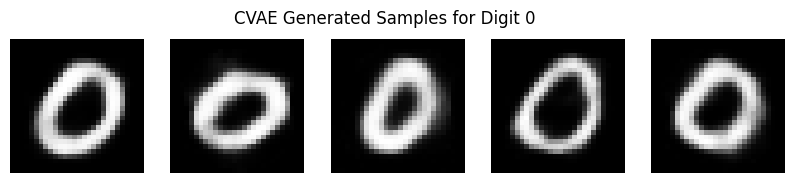

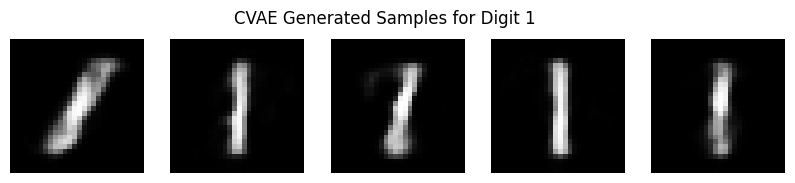

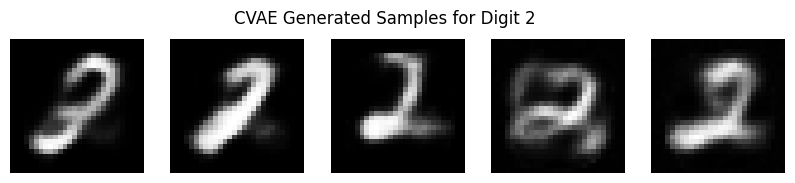

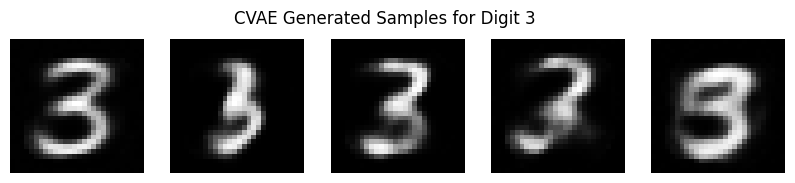

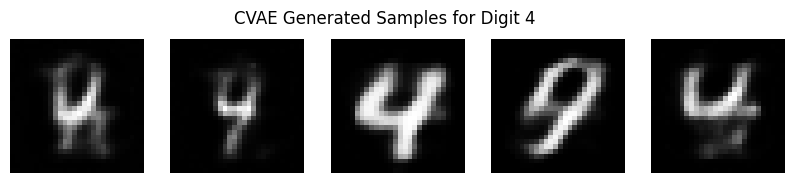

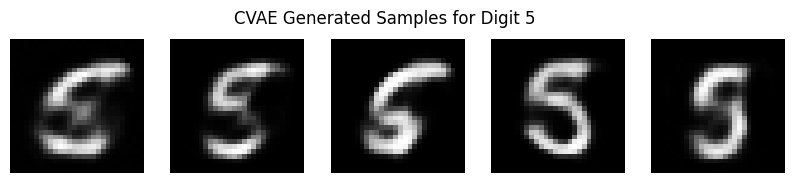

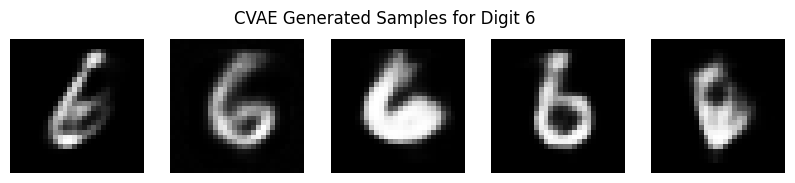

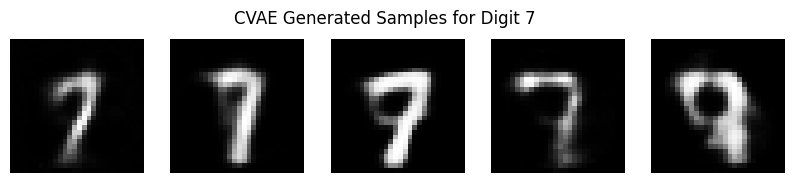

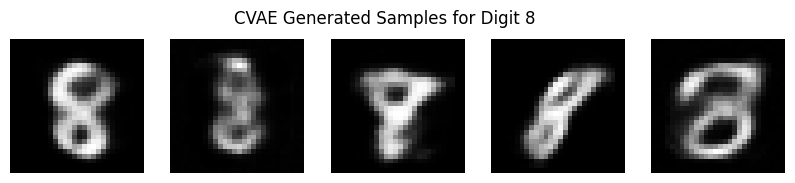

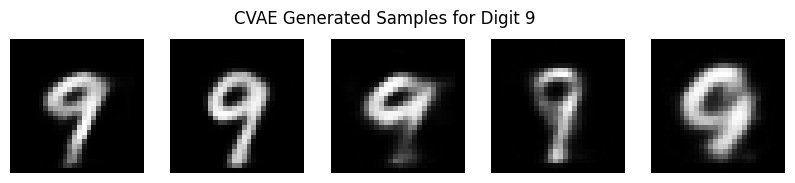

In [10]:
#Visualize generated samples from the CVAE for all digit classes
def visualize_cvae_generation(model, digit_class, n_samples, device):
    """

    Uses the trained CVAE to generate samples for a given MNIST digit.

    Args:
      model: the trained CVAE model.
      digit_class: target digit (integer 0-9) to condition on.
      n_samples: number of images to generate.
      device: computation device.
    """

    model.eval()
    with torch.no_grad():
        # Create one-hot encoded labels for the given digit.
        y = torch.zeros(n_samples, 10, device=device)
        y[:, digit_class] = 1.0
        # Sample latent vectors from standard normal.
        latent_dim = model.fc21.out_features
        z = torch.randn(n_samples, latent_dim, device=device)
        x_generated = model.decode(z, y)
        # Reshape images (assumes MNIST 28x28).
        x_generated = x_generated.view(-1, 28, 28).cpu().numpy()

    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(x_generated[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"CVAE Generated Samples for Digit {digit_class}")
    plt.show()


for digit in range(10):
    visualize_cvae_generation(cvae_model, digit_class=digit, n_samples=5, device=device)